In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import preprocessing
from sklearn.externals.six import StringIO
# import pydotplus
from IPython.display import Image
from IPython.display import display 

import graphviz

In [2]:
# Reference
# http://www.ke.tu-darmstadt.de/lehre/archiv/ws0809/mldm/dt.pdf
def calc_var_entropy(df, var):
    total_count = len(df)
    levels = df[var].unique()
    per_level_count = df.groupby(by=var).agg('count').values[:,0]
    prob = map(lambda x: x/float(total_count), per_level_count)
    neglog = map(lambda x: -x*np.log2(x), prob)
    entropy = reduce(lambda x,y: x+y, neglog)
    return entropy

def gain_ratio(df, features, target):
    total_count = len(df)
    target_entropy = calc_var_entropy(df, target)
    gain_ratio_df = pd.DataFrame(columns=['feature', 'gain_ratio'])
    
    for feat in features:
        target_entropy_per_feat_level = df.groupby(by = feat).apply(lambda dfnow: calc_var_entropy(dfnow, target)).values
        per_level_count = df.groupby(by = feat).agg('count').values[:,0]
        prob = map(lambda x: x/float(total_count), per_level_count)
        neglog = map(lambda (prob_this_level, target_entropy_this_level): -prob_this_level*target_entropy_this_level,
                         zip(prob, target_entropy_per_feat_level))
        gain = target_entropy + np.sum(neglog)
        split_info = calc_var_entropy(df, feat)
        gain_ratio = gain/float(split_info)
        gain_ratio_df = pd.concat((gain_ratio_df,
                                  pd.DataFrame(columns=['feature', 'gain_ratio'],
                                              data = [(feat, gain_ratio)])))
    gain_ratio_df.sort_values(by = ['gain_ratio'], ascending = False, inplace = True)
    gain_ratio_df.reset_index(inplace = True, drop = True)
    return gain_ratio_df

dft = pd.read_excel('IG_sample.xlsx', sheetname='PlayGolf')
display(dft)
display( 'Entropy for PlayGolf: {0:.3f}'.format(calc_var_entropy(dft, 'PlayGolf')) )
display(gain_ratio(dft, ['Outlook', 'Temperature', 'Humidity', 'Windy'], 'PlayGolf'))


,Day,Temperature,Outlook,Humidity,Windy,PlayGolf
0,2017-07-05,hot,sunny,high,False,no
1,2017-07-06,hot,sunny,high,True,no
2,2017-07-07,hot,overcast,high,False,yes
3,2017-07-09,cool,rain,normal,False,yes
4,2017-07-10,cool,overcast,normal,True,yes
5,2017-07-12,mild,sunny,high,False,no
6,2017-07-14,cool,sunny,normal,False,yes
7,2017-07-15,mild,rain,normal,False,yes
8,2017-07-20,mild,sunny,normal,True,yes
9,2017-07-21,mild,overcast,high,True,yes


'Entropy for PlayGolf: 0.940'

,feature,gain_ratio
0,Outlook,0.156428
1,Humidity,0.151836
2,Windy,0.048849
3,Temperature,0.018773


In [3]:
feat_col = ['Temperature', 'Outlook', 'Humidity', 'Windy']
targ_col = ['PlayGolf']

le_all = []
for col in feat_col+targ_col:
    le = preprocessing.LabelEncoder()
    val = le.fit_transform(dft[col])
    dft[col+'_label'] = val
    le_all.append(le)

display(dft.head(3))

,Day,Temperature,Outlook,Humidity,Windy,PlayGolf,Temperature_label,Outlook_label,Humidity_label,Windy_label,PlayGolf_label
0,2017-07-05,hot,sunny,high,False,no,1,2,0,0,0
1,2017-07-06,hot,sunny,high,True,no,1,2,0,1,0
2,2017-07-07,hot,overcast,high,False,yes,1,0,0,0,1


In [4]:
feat_col_label = map(lambda x: x+'_label', feat_col)
targ_col_label = map(lambda x: x+'_label', targ_col)

X = dft[feat_col_label]
y = dft[targ_col_label]

print X.shape
print y.shape

clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X, y)

(14, 4)
(14, 1)


In [5]:
n_nodes = clf.tree_.node_count
print("The binary tree structure has %s nodes" % n_nodes)

The binary tree structure has 13 nodes


In [6]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("ig_example")

'ig_example.pdf'

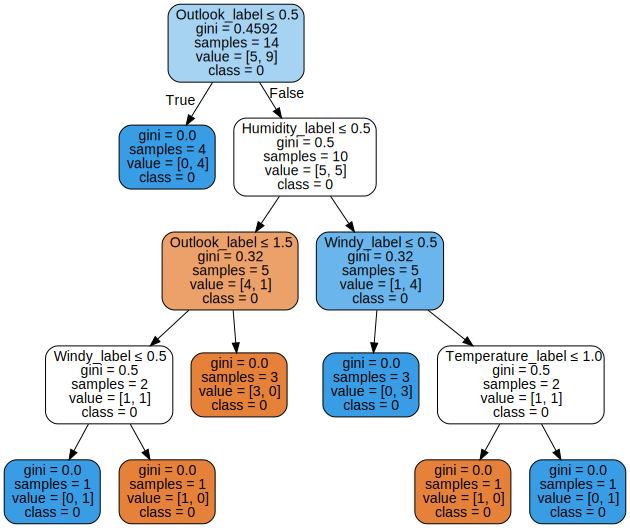

In [7]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                 feature_names=feat_col_label, 
                                 class_names=dft[targ_col_label].astype('str').values.reshape(1,-1)[0],
                                 filled=True, rounded=True,  
                                 special_characters=True
                               )
graph = graphviz.Source(dot_data)
graph